(80, 80, 3)


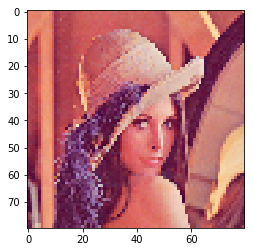

In [233]:
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

img = Image.open('images/lenna.png')
img = img.resize(size=(80,80))
img_mtx = np.array(img)

print(img_mtx.shape)
plt.imshow(img_mtx)

In [240]:
def diffuse(t, x, p):
    x = x.reshape(p['size'])   
    dxdt = np.zeros(p['size'])
                
    for r in range(p['size'][0]):
        for c in range(p['size'][1]):
            
            diffusion = [None]*p['size'][2]
            for i in range(p['size'][2]):
                # left boundary
                if r == 0:
                    diffusion_row = p['D'][i]/p['dr']**2 * (           - x[r,c,i] + x[r+1,c,i])
                # right boundary
                elif r == p['size'][0]-1:
                    diffusion_row = p['D'][i]/p['dr']**2 * (x[r-1,c,i] - x[r,c,i])
                # bulk
                else:
                    diffusion_row = p['D'][i]/p['dr']**2 * (x[r-1,c,i] - 2*x[r,c,i] + x[r+1,c,i])
                # upper boundary
                if c == 0:
                    diffusion_col = p['D'][i]/p['dc']**2 * (           - x[r,c,i] + x[r,c+1,i])
                # lower boundary
                elif c == p['size'][1]-1:
                    diffusion_col = p['D'][i]/p['dc']**2 * (x[r,c-1,i] - x[r,c,i])
                # bulk
                else:
                    diffusion_col = p['D'][i]/p['dc']**2 * (x[r,c-1,i] - 2*x[r,c,i] + x[r,c+1,i])
                
                # total diffusion in two dimensions
                diffusion[i] = diffusion_row + diffusion_col
                
            #dxdt[r,c,0] = diffusion[0] + p['k1']*x[r,c,0]*x[r,c,1] - p['k3']*x[r,c,0]
            #dxdt[r,c,1] = diffusion[1] - p['k1']*x[r,c,0]*x[r,c,1] + p['k3']*x[r,c,2]
            #dxdt[r,c,2] = diffusion[2] - p['k2']*x[r,c,2]*x[r,c,0] + p['k3']*x[r,c,1]
            
            #dxdt[r,c,0] = diffusion[0] + p['k1']*x[r,c,1] - p['k3']*x[r,c,0] - p['k2']*x[r,c,2]
            #dxdt[r,c,1] = diffusion[1] - p['k2']*x[r,c,0] + p['k3']*x[r,c,2] + p['k3']*x[r,c,1]
            #dxdt[r,c,2] = diffusion[2] - p['k2']*x[r,c,1] + p['k3']*x[r,c,0] - p['k3']*x[r,c,2]  
            
            #dxdt[r,c,0] = diffusion[0] - p['k3']*x[r,c,0] + p['k1']*x[r,c,1] - p['k2']*x[r,c,2]
            #dxdt[r,c,1] = diffusion[1] - p['k2']*x[r,c,0] + p['k3']*x[r,c,1] + p['k3']*x[r,c,2]
            #dxdt[r,c,2] = diffusion[2] + p['k3']*x[r,c,0] - p['k2']*x[r,c,1] - p['k3']*x[r,c,2]
            
            dxdt[r,c,0] = diffusion[0] + p['k3']*x[r,c,0]*x[r,c,1] - p['k1']*x[r,c,2]*x[r,c,0]
            dxdt[r,c,1] = diffusion[1] - p['k4']*x[r,c,0]*x[r,c,1] + p['k2']*x[r,c,2]*x[r,c,1] 
            dxdt[r,c,2] = diffusion[2] + p['k4']*x[r,c,0]*x[r,c,2] - p['k3']*x[r,c,1]*x[r,c,2]

    return dxdt.ravel()
            
def euler_forward(dxdt, x, t_span, p):
    
    x_span = [x.copy()]
    for t in tqdm(t_span):
        x += dxdt(t, x, p)
        x_span.append(x.copy())  
        #print(min(x), max(x))
    return x_span[:-1]
    
t_span = np.arange(0,15,0.1)
x0 = img_mtx.ravel()/255 
p = {'size': img_mtx.shape,
     'dr': 1,
     'dc': 1,
     'D': [0.08, 0.05, 0.1],
     'k1': 0.20,#0.25
     'k2': 0.15,#0.18
     'k3': 0.10,#0.15
     'k4': 0.05}


img_development = euler_forward(diffuse, x0, t_span, p)


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:26<00:00,  5.77it/s]


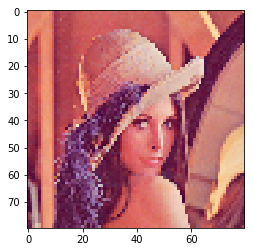

In [238]:
def convert2img(x, size):
    # reshape
    x = x.reshape(size)
    
    # rescale into (0,1)
    #x = 1/(1 + np.exp(-10*x+4.5))    
    x = np.clip(x, 0, 1)
    
    # rescale into (0,255) ints
    x *= 255
    x = x.astype(np.uint8)
    
    # add transparency channel and set each val to 255 (no transparency)
    x = np.concatenate((x, 255*np.ones((p['size'][0], p['size'][1], 1), dtype=np.uint8)), axis=2)
    
    return  x

for x in img_development[0:1]:
    x = convert2img(x, p['size'])
    plt.imshow(x)

In [241]:
from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import Div
from bokeh.layouts import row, column
from bokeh.palettes import Colorblind
from  ipywidgets import interact
output_notebook()


#data = convert2img(img_development[i], p['size'])
img_data = ColumnDataSource({'img': [np.flipud(convert2img(img_development[0], p['size']))]})

pb = figure(x_range=(0,p['size'][0]), y_range=(0,p['size'][1]),
            plot_width=p['size'][0]*4, plot_height=p['size'][1]*4)
#r = pb.image_rgba(image=[np.flipud(data)], x=0, y=0, dw=100, dh=60)
r = pb.image_rgba(image='img', source=img_data, x=0, y=0, dw=p['size'][0], dh=p['size'][1])
show(pb, notebook_handle=True)

def update(t=0):
    r.data_source.data['img'] = [np.flipud(convert2img(img_development[t], p['size']))]
    push_notebook()
    
    
interact(update, t=(0,len(t_span)-1,1))

Loading BokehJS ...

interactive(children=(IntSlider(value=0, description='t', max=149), Output()), _dom_classes=('widget-interact',))

<function __main__.update>

In [231]:
p['size']

(80, 80, 3)